In [1]:
import re 

def conv(x): # 1-200 scale to 20-80
    if type(x) is str:
        x = int(x)
    r = x*60.0/200+20 # 0 -> 20, 200 -> 80
    return int(round(r/5)*5)

def findPlayerId(ln):
    match = re.search("player_(\d+).html",ln)
    return int(match.group(1))

In [2]:
# Stop using - Read players' rating - it will miss FA players (a lot)
'''
raw_ratings = open(PATH_TO_SAVE_BASE + r"\import_export\fbl_rosters.txt").readlines()
attributes = [x.strip() for x in [ln for ln in raw_ratings if ln.startswith("//id,")][0].strip()[2:].split(",")]
rating_list = [dict(zip(attributes, data.split(","))) for data in raw_ratings if data.startswith("//")== False]
rating_map = dict((p['id'], p) for p in rating_list)
print (attributes)
'''

'\nraw_ratings = open(PATH_TO_SAVE_BASE + r"\\import_export\x0cbl_rosters.txt").readlines()\nattributes = [x.strip() for x in [ln for ln in raw_ratings if ln.startswith("//id,")][0].strip()[2:].split(",")]\nrating_list = [dict(zip(attributes, data.split(","))) for data in raw_ratings if data.startswith("//")== False]\nrating_map = dict((p[\'id\'], p) for p in rating_list)\nprint (attributes)\n'

In [3]:
def path_to_save_base(savefilename):
    return r'C:\Users\goreh\OneDrive\문서\Out of the Park Developments\OOTP Baseball 24\saved_games/' + savefilename + '.lg'


In [4]:
import pandas
def load_dumped_csv(savefilename, filename):
    return pandas.read_csv(path_to_save_base(savefilename) + r"/import_export/csv/" + filename + ".csv")

def load_players(savefilename):
    p = load_dumped_csv(savefilename, 'players')    
    bat = load_dumped_csv(savefilename, 'players_batting')
    pit = load_dumped_csv(savefilename, 'players_pitching')

    return p.merge(bat, on='player_id').merge(pit, on='player_id')

def load_player_rating_map(savefilename):
    players_df = load_players(savefilename)
    rating_map = players_df.set_index('player_id').T.to_dict()

    return rating_map

In [5]:
# Games
# OOTP Baseball 23\saved_games\Damanse.lg\news\txt\leagues
def load_logs(savefilename):
    fn = []
    for findex in range(1,14188):
        try:
            fn += [x[0:4] + str(findex) + x[4:] for x in open(path_to_save_base(savefilename) + "/news/txt/leagues/log_{}.txt".format(findex)).readlines()]
        except:
            pass
    return [ln.strip() for ln in fn]

In [6]:
def result_parse(ln):
    if "Fly out" in ln:
        return "FO"
    if "Base on Balls" in ln:
        return "BB"
    if "Strikes out" in ln:
        return "SO"
    if "Ground out" in ln or "Grounds out" in ln:
        return "GO"
    if "Hit by Pitch" in ln:
        return "HBP"
    if "Grounds into double play" in ln or "Grounds into DOUBLE play" in ln:
        return "GIDP" # 땅볼 - 병살타
    if "<b>SINGLE</b>" in ln:
        return "H1"
    if "<b>DOUBLE</b>" in ln:
        return "H2"
    if "<b>TRIPLE</b>" in ln:
        return "H3"
    if "HOME RUN</b>" in ln:
        return "HR"
    if "Intentional Walk" in ln:
        return "IBB"
    if "Reached on error" in ln or "Reached via error" in ln:
        return "ERR"
    if "Fielders Choice" in ln:
        return "FielderC" # 야수 선택
    if "Grounds into fielders choice" in ln:
        return "FielderC" # 위에랑 차이점?
    if "Sac Bunt" in ln:
        if "batter safe" in ln: # bunt hit
            return "H1-SacBunt"
        return "SacBunt"
    if "Single, Error in" in ln:
        return "H1+Err"
    if "Bunt for hit " in ln:
        if "batter safe" in ln:
            return "H1-Bunt" # to make sure all runner safe
        return "GO-Bunt"
    if "Bunt - Flyout" in ln:
        return "FO-Bunt"
    if "Squeeze Bunt" in ln:
        if "runner OUT" in ln: # bunt fail
            return "FC-sqzbunt"
        if "runner scores, batter safe" in ln: # hit
            return "H1-SqzBunt"
        return "SacBunt-SqzBunt"
    if "Reaches on Catchers interference" in ln: 
        return "ERR-Inference" # 스윙방해
    
    if "Pickoff Throw " in ln or "Pickoff Play " in ln:
        return "PICKOFF" # 견제사
    if "is caught stealing " in ln:
        return "STEALFAIL" # 도루실패
    
    if re.search("3-[0-2]: Ball", ln) != None:
        # actually base on balls, not sure why it's just expressed as a ball
        return "BB"
    
    if "SINGLE, rundown," in ln:
        return "H1+RunDown"
    
    if "SINGLE, but batter called out on appeal for missing first base!" in ln:
        return "H1+MissingBase" # 1루 안밟아서 아웃
    
    if "Bunted foul, Strikeout!" in ln or "Bunt missed, Strikeout!" in ln:
        return "SO-Bunt" # 쓰리번트실패 삼진아웃
    return None

def analysis(fn, rating_map):
    resultCountMap = {}
    stuVsAvkMap = {}
    for i in range(len(fn)):
        ln = fn[i]
        
        if "Pitching: " in ln or ("Top of the " in ln or "Bottom of the " in ln) and "Pitching for" in ln: # inning start with pitcher introd
            # [%T]	Top of the 1st - New York Yankees batting - Pitching for Texas Rangers : RHP <a href="../players/player_31742.html">Spencer Howard</a>
            try:
                pitcher_id = findPlayerId(ln)
            except Exception as E:
                pitcher_id = None
            batter_id = None
            
        if "Batting: " in ln or "Pinch Hitting:" in ln or re.search("Top of the [1-9a-z]* over", ln) != None: # new batter or inning end
            if batter_id != None:
                # find prev result
                found = False
                for j in range(i-1,-1,-1):
                    if re.search(r"\[%N\]\d+\s*\d-\d", fn[j]) != None or \
                        re.search("Pickoff (Play|Throw) .*(OUT|Out)", fn[j]) != None or \
                        re.search("is caught stealing [1-3a-z]* base", fn[j]) != None or \
                        re.search("SINGLE, rundown,", fn[j]) != None or \
                        re.search("SINGLE, but batter called out on appeal for missing first base!", fn[j]) != None: # result
                        
                        if not pitcher_id in rating_map:
                            found=True
                            break
                            
                        if not batter_id in rating_map:                   
                            found=True
                            break

                        pit = rating_map[pitcher_id]
                        bat = rating_map[batter_id]
                        
                        result = result_parse(fn[j])
                        
                        resultCountMap[result] = resultCountMap.get(result, 0) + 1
                        
                        bat_h = bat['bats']
                        pit_h = 'r' if pit['throws'] == 1 else 'l'

                        if bat_h == '3':
                            bat_h = 'l' if pit_h == 'r' else 'r'
                        elif bat_h == '1':
                            bat_h = 'r'
                        else:
                            bat_h = 'l'

                        key = (conv(pit['pitching_ratings_vs' + bat_h + '_stuff']), conv(bat['batting_ratings_vs' + pit_h + '_strikeouts']))
                        so,ab = stuVsAvkMap.get(key, (0,0))
                        if result in ["SO-Bunt", "SO", "FO", "GO", "H1", "H2", "H3", "HR", "H1-SacBunt", "H1-Bunt", "GO-Bunt", "FO-Bunt", "H1+RunDown", "H1+MissingBase"]:
                            ab += 1
                        if result in ["SO-Bunt", "SO"]:
                            so += 1
                        stuVsAvkMap[key] = (so,ab)
                        
                        if result == None:
                            print (">>> P. {} {} vs B. {} {}".format(
                                pit["first_name"], pit["last_name"],
                                bat["first_name"], bat["last_name"]
                            ))
                            print (fn[j-2])
                            print (fn[j-1])
                            print (fn[j])
                            print (fn[j+1])
                            print (fn[j+2])
                        found = True
                        break
                if found == False:
                    raise Exception("couldn't find result")
            if "Batting: " in ln or "Pinch Hitting:" in ln:
                # new batter
                batter_id = findPlayerId(ln)
        
    total = sum(resultCountMap.values())
    #print (total)

    translate_map = {
        'FO': '뜬공아웃',
        'GO': '땅볼아웃',
        'SO': '삼진아웃',
        'BB': '볼넷',
        'HBP': '몸에 맞는 공',
        'IBB': '고의사구',
        'H1': '1루타',
        'H1+Err': '1루타 후 에러로 추가진루',
        'H2': '2루타',
        'H3': '3루타',
        'HR': '홈런',
        'FielderC': '야수선택',
        'ERR': '에러출루',
        'GIDP': '병살',
        'SacBunt': '희생번트',
        'STEALFAIL': '도루실패-이닝종료',
        'GO-Bunt': '번트실패-땅볼아웃',
        'FO-Bunt': '번트실패-뜬공아웃',
        'H1+RunDown': '1루타/런다운 아웃',
        'H1-Bunt': '번트안타',
        'H1+MissingBase': '누의 공과 범타',
        'ERR-Inference': '스윙 방해 진루',
        'FC-sqzbunt': '스퀴즈번트 실패',
        'H1-SqzBunt': '스퀴즈번트 안타',
        'PICKOFF': '견제사로 이닝종료',
        'H1-SacBunt': '희생번트 안타', #???
        'SO-Bunt': '스리번트 아웃'
    }

    '''
    for result,count in sorted(resultCountMap.items(),key=lambda x: -x[1]):
        print ("{} {}".format(translate_map[result],count),"{:.4f}%".format(count*100.0/total))
    '''

    data = []
    for stu in range(20,85,5):
        row = []
        for avk in range(20,85,5):
            so,ab=stuVsAvkMap.get((stu,avk),(0,0))
            row += [(so,ab)]
        data += [row]
    return data
            

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Example 2D list

def show_heat_map(data_raw):
    # Convert the 2D list to a numpy array
    data = [[t[0]/t[1]*100 if t[1]>50 else 0 for t in row] for row in data_raw]
    data_array = np.array(data)

    # Create the plot
    plt.imshow(data_array, cmap='Reds', vmin=0, vmax=50)
    plt.colorbar()

    plt.xlabel('Batter AvoidK')
    plt.ylabel('Pitcher Stuff (as SP)')
    plt.title('Strike out/AB')

    # Add labels and title
    ratings = list(range(20,85,5))
    plt.xticks(np.arange(len(ratings)), ratings)
    plt.yticks(np.arange(len(ratings)), ratings)

    for i in range(len(ratings)):
        for j in range(len(ratings)):
            if data[i][j] > 0:
                plt.text(j, i, "{:.1f}%\n{}".format(data[i][j],data_raw[i][j][1]), ha='center', va='center', color='black', fontsize=6)

    # Display the plot
    plt.gca().invert_yaxis()
    plt.show()

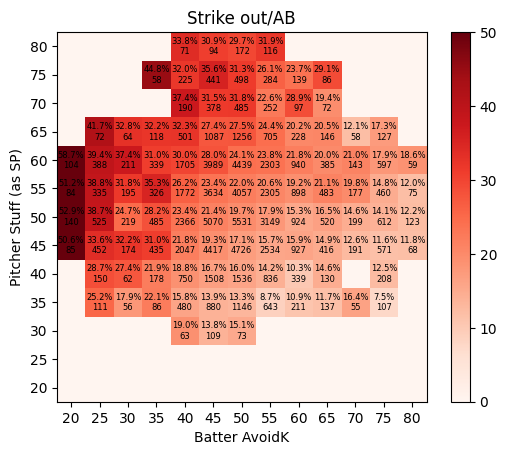

In [15]:
data1 = analysis(load_logs('test_1000'), load_player_rating_map('test_1000'))
show_heat_map(data1)

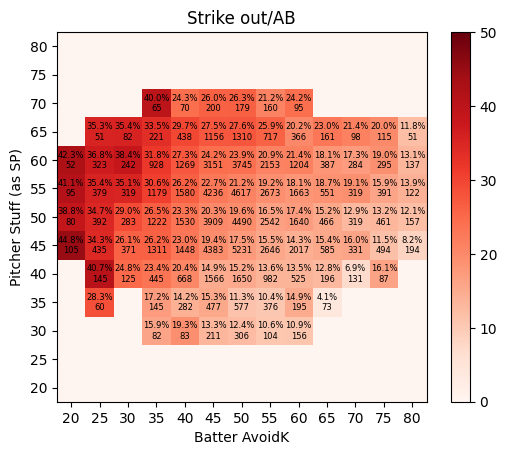

In [16]:
data2 = analysis(load_logs('test_1001'), load_player_rating_map('test_1001'))
show_heat_map(data2)

>>> P. Aaron Twining vs B. Danny Hughes
[%N]746	2-0: Ball
[%N]746	3-0: Called Strike
[%N]746	3-1: Called Strike
[%N]746	<b>Steal of home, <a href="../players/player_905.html">Matt Schuett</a> is out</b>
[%F]746	Top of the 3rd over - 0 runs, 0 hits, 0 errors, 0 left on base; Detroit 1 - Phoenix 3


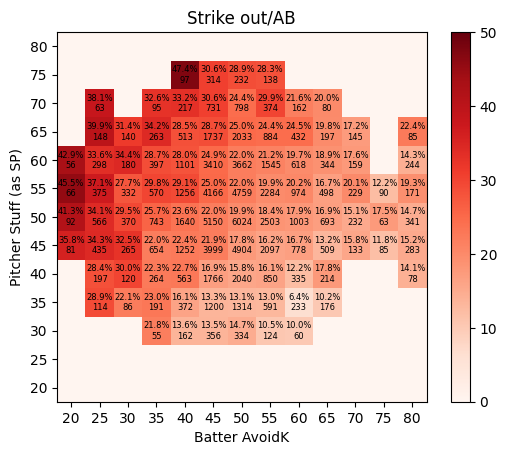

In [17]:
data3 = analysis(load_logs('test_1002'), load_player_rating_map('test_1002'))
show_heat_map(data3)

>>> P. Tim Lee vs B. Jeff Murphy
[%N]130	1-1: Hit by Pitch
[%B]130	Batting: SHB <a href="../players/player_128.html">Jeff Murphy</a>
[%N]130	0-0: Lines into TRIPLE play, 4-6-3 (Line Drive, 4, EV 72.5 MPH)
[%F]130	Top of the 6th over - 0 runs, 1 hit, 0 errors, 0 left on base; Jacksonville 2 - Baltimore 3
[%T]130	Bottom of the 6th - Baltimore Toros batting - Pitching for Jacksonville Express : LHP <a href="../players/player_1017.html">Arturo Cortes</a>


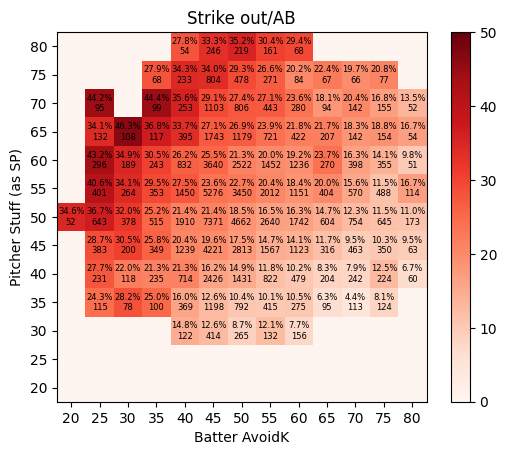

In [18]:
data4 = analysis(load_logs('test_1003'), load_player_rating_map('test_1003'))
show_heat_map(data4)

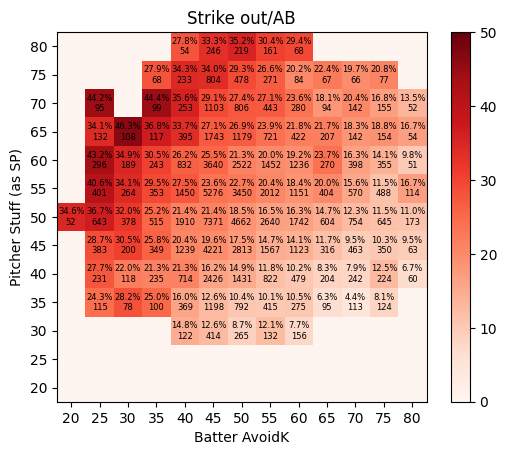

In [19]:
data5 = analysis(load_logs('test_1004'), load_player_rating_map('test_1004'))
show_heat_map(data4)

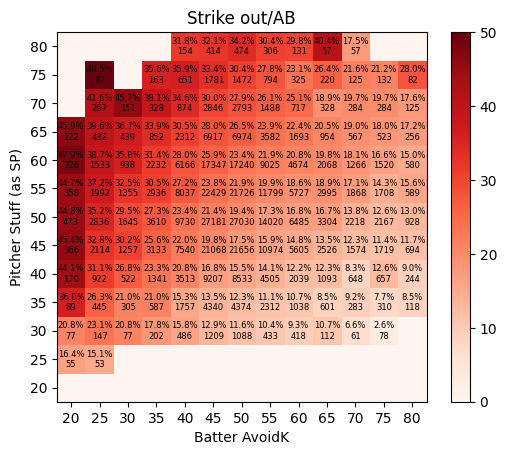

In [20]:
data = []
targets = [data1, data2, data3, data4, data5]
for i in range(len(data1)):
    r = []
    for j in range(len(data1[0])):
        a = sum([t[i][j][0] for t in targets])
        b = sum([t[i][j][1] for t in targets])
        r.append((a,b))
    data.append(r)

show_heat_map(data)